In [18]:
from qutip import ket2dm, basis, Options
import numpy as np
from maze import Maze
from sqwalk import QWalker
import matplotlib.pyplot as plt

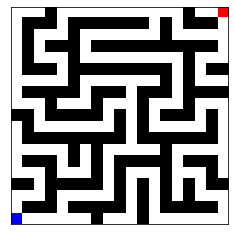

In [19]:
# Initialize the graph, in this case a perfect square maze having the side dimension equal to "size".
# The entrance is in the lower left corner and the exit in the upper right corner.
size = 10
graph = Maze(maze_size=(size, size), startNode=0, sinkNode=size*size-1)

# Let's plot it for visual reference
_ = graph.plot_maze()

In [20]:
# Inizialize the quantum walker that will move on the graph
walker = QWalker(graph.adjacency, noise_param=0.1, sink_node=graph.sinkNode)

# The initial state is obtained by just placing all the population on the starting node
dim = graph.total_nodes + 1
initial_quantum_state = ket2dm(basis(dim, graph.startNode))
initial_quantum_state

Quantum object: dims = [[101], [101]], shape = (101, 101), type = oper, isherm = True
Qobj data =
[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

In [21]:
# Run the walker for 1000 steps and save the final state to resume it later
opts = Options(store_states=False, store_final_state=True)
result = walker.run_walker(initial_quantum_state, time_samples=1000, opts=opts)
new_state = result.final_state
print('Executed 1000 steps of SQW.')

Executed 1000 steps of SQW.


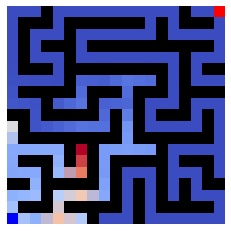

In [22]:
# We plot the population overlayed on the maze to visualize how the walker is moving along the graph
img, ax = graph.plot_maze(show=False)
plt.axis('off')

diagQS = new_state.diag()
diagQS = diagQS/np.max(diagQS)
cmap = plt.cm.get_cmap('coolwarm')
norm = plt.Normalize(0, 1)
for n in range(diagQS.size - 1):  # -1  because the last one is the sink
    x, y = graph.node2xy(n)
    img[y, x, :] = cmap(norm(diagQS[n]))

for link in range(1, graph.total_links + 1):
    x, y = graph.link2xy(link)
    if graph.get_link(link) > 0:
        if 1 <= link <= graph.vertical_links and not np.array_equal(img[y + 1, x, :], [1, 1, 1, 1]) \
                and not np.array_equal(img[y - 1, x, :], [1, 1, 1, 1]):
            img[y, x, :] = (img[y + 1, x, :] + img[y - 1, x, :]) / 2
        elif graph.vertical_links < link <= graph.total_links and not np.array_equal(img[y, x + 1, :], [1, 1, 1, 1]) \
                and not np.array_equal(img[y, x - 1, :], [1, 1, 1, 1]):
            img[y, x, :] = (img[y, x + 1, :] + img[y, x - 1, :]) / 2

x, y = graph.node2xy(graph.startNode)
img[y, x, :3] = 0, 0, 1

x, y = graph.node2xy(graph.sinkNode)
img[y, x, :3] = 1, 0, 0

ax = plt.imshow(img, origin='lower')
plt.show()

In [23]:
# We resume the walker from the previous state and at the end we compute the amount of population exited from the maze.

result = walker.run_walker(new_state, time_samples=5000, opts=opts)
print('Fraction of population exited from the maze: ', np.real(result.final_state.full()[dim-1, dim-1]))

Fraction of population exited from the maze:  0.025852269805260987
